<a href="https://colab.research.google.com/github/NickPavlovskii/sber/blob/main/sber_prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача: необходимо построить модель, которая оценивает обьем стабильной части средств на дату.


-  сделать прогноз объема расчетных счетов физических лиц на 1М, 2М, 3М...или др, 
- далее расчитывать минимальное значение объема `value` за данный промежуток. 

То есть после того, как сделал прогноз на промежуток 1 месяц, необходимо определить значение, ниже которого не опускается объема расчетных счетов физических лиц. 





- попробоать Квантильную регрессию 
- попробовать применить нормализацию данных (привести к некоторой шкале, но может и ухудшить предсказания) (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

-  попробовать модель градиентного бустинга на деревьях, например посмотреть такой туториал (https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)






 оглавление для проверяющего:\
[1. Подготовка данных](#step_0) \
[2. Модель 1](#Arima )\
[3. Модель 2](#step_2) \
[4. Минимум в месяц](#step_3) \
[5. Skforecast](#step_4) \
[6. Обогатим данные](#step_5) \
[7. Лин регрессия](#step_6) \
[8. xgboost](#step_7) \
[9. Решение Сбера](#step_8) \


Загрузим данные и посмотрим на них

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
# для исследования сезонности, тренда в данных
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

from pylab import rcParams

import warnings
import itertools

# для форматирования графиков
%matplotlib inline
plt.rcParams.update({'font.size': 15, 
                     'figure.figsize': (18, 8), 
                     'axes.grid' : True})

<a id='step_0'></a>
# Подготовка данных

In [162]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dataset.dropna(subset=['value'], how='all')


,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


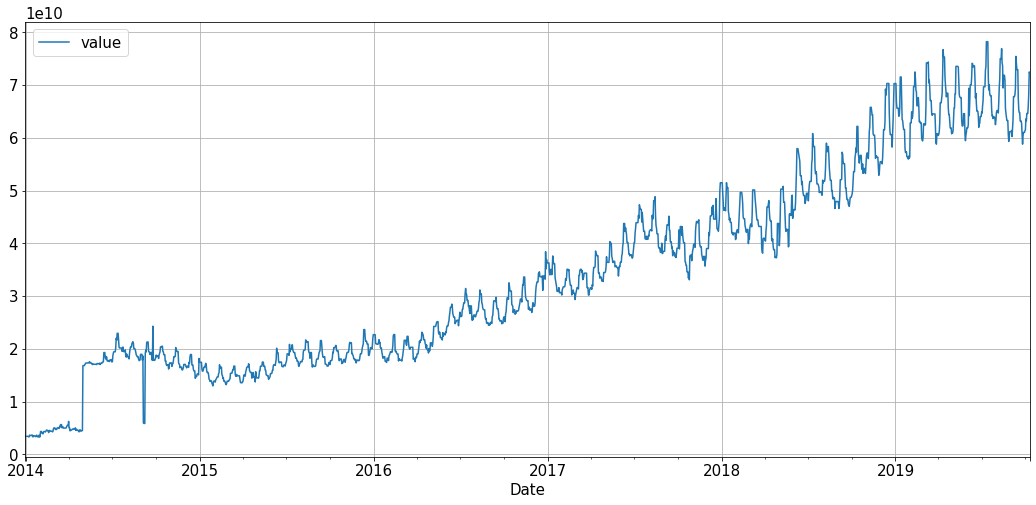

In [163]:



dataset.plot(y='value')

Попробуем избавиться от этого видимого выброса 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


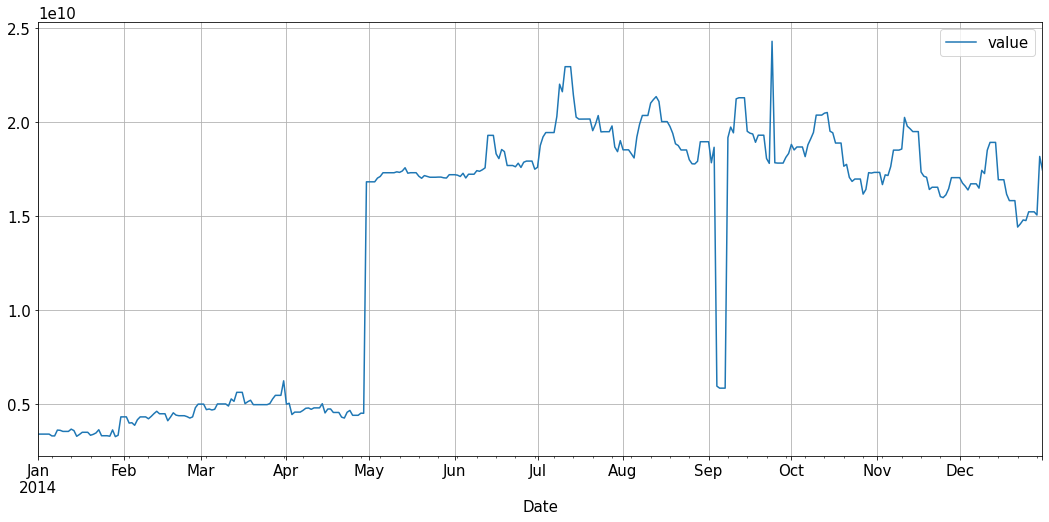

In [164]:

dataset['2014'].plot(y='value')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


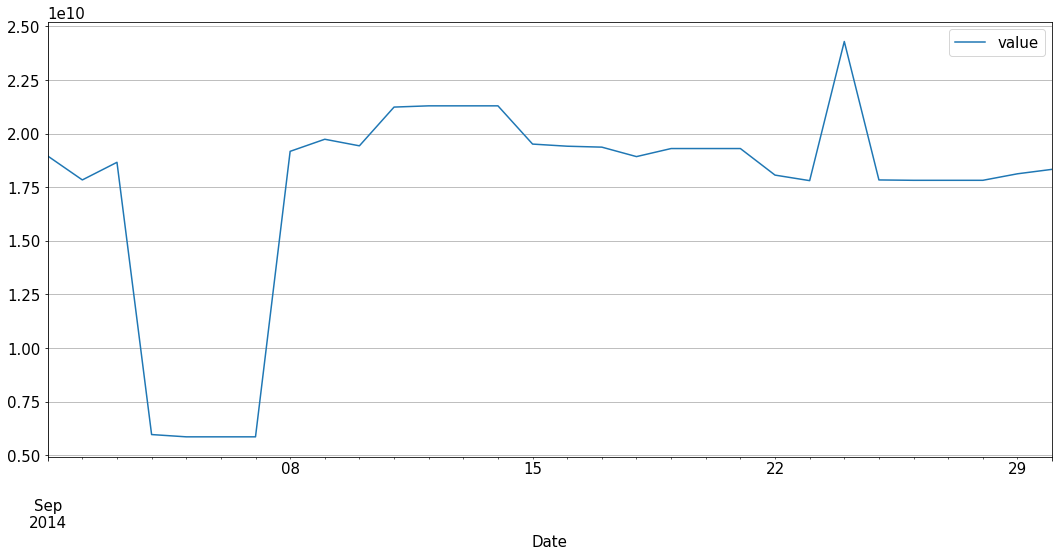

In [165]:
dataset['2014-09'].plot(y='value')


In [166]:
dataset=dataset.drop(['2014-09-02','2014-09-03','2014-09-04','2014-09-05','2014-09-06','2014-09-07','2014-09-23','2014-09-24','2014-09-25'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


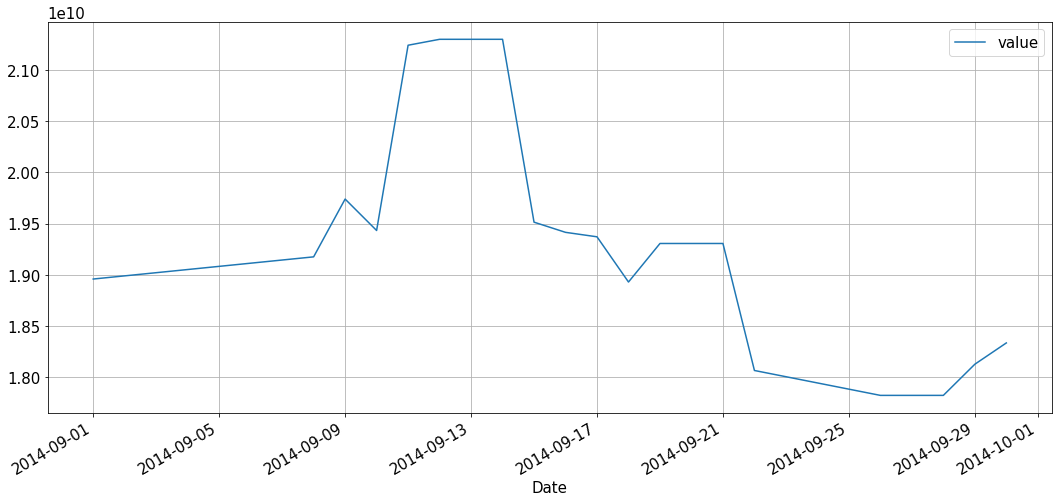

In [167]:
dataset['2014-09'].plot(y='value')


In [168]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2102 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2102 non-null   int64
dtypes: int64(1)
memory usage: 32.8 KB


In [169]:
print(f'Number of rows with missing values: {dataset.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


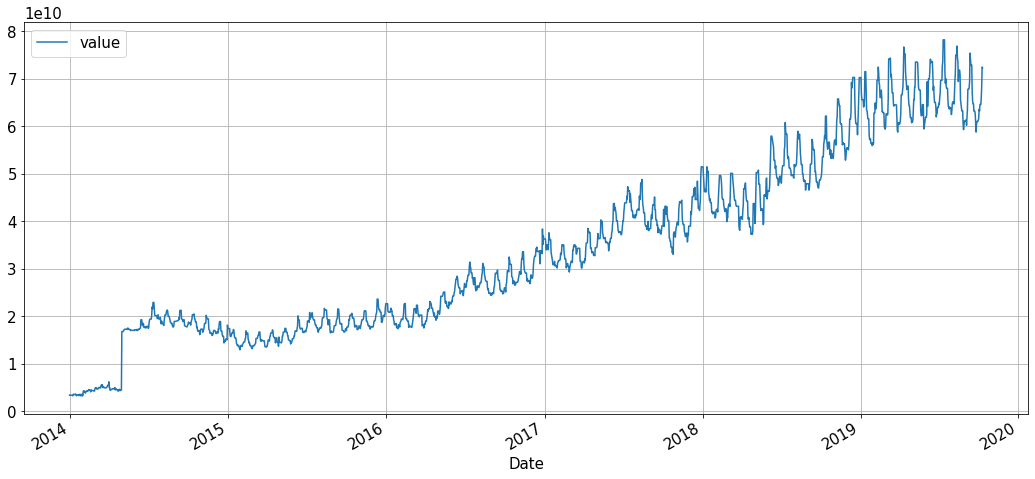

In [170]:
dataset.plot(y='value')

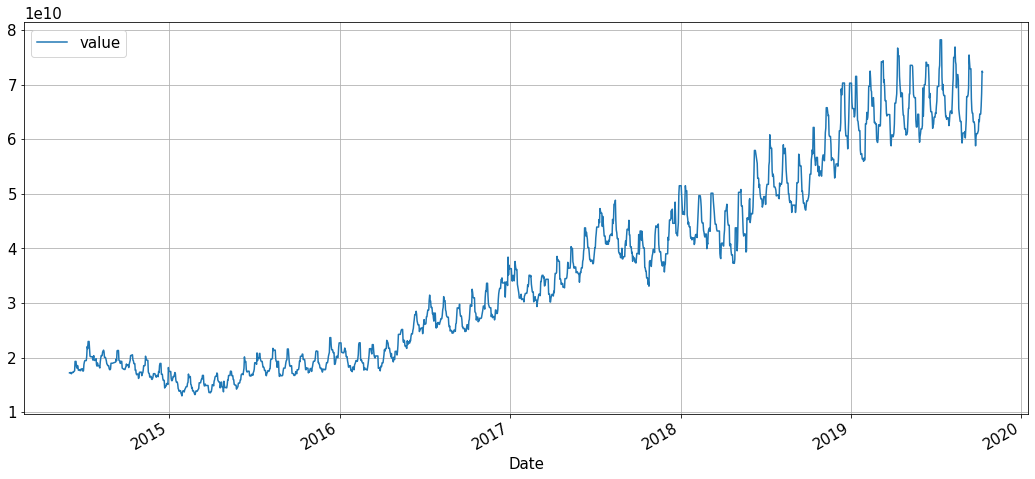

In [171]:
dataset=dataset['2014-06':]
dataset.plot(y='value')

In [172]:
# Определяем функцию для теста ADF
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf 
adf_test(dataset)

Results of Dickey-Fuller Test:
Test Statistic                    0.890555
p-value                           0.992966
#Lags Used                       26.000000
Number of Observations Used    1922.000000
Critical Value (1%)              -3.433757
Critical Value (5%)              -2.863045
Critical Value (10%)             -2.567571
dtype: float64


Видим,что график имеет выбросы. Так анализировать закрытие/открытие счетов за каждые день не имеет смысла, поэтому перейдем к неидеальному интервалу и среднему значению счетов на нем, тем самым уменьшим колебания нашего временного ряда

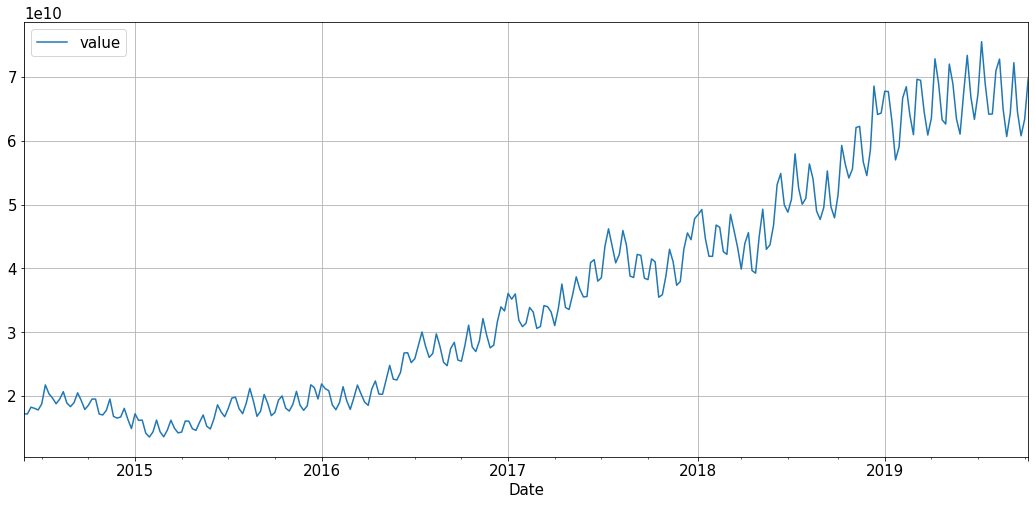

In [173]:
dataset1 = dataset.resample('W').agg('mean')

dataset1.plot(y='value')

In [174]:
dt = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dt.dropna(subset=['value'], how='all')

,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [175]:
dataset1 = dataset1.interpolate()

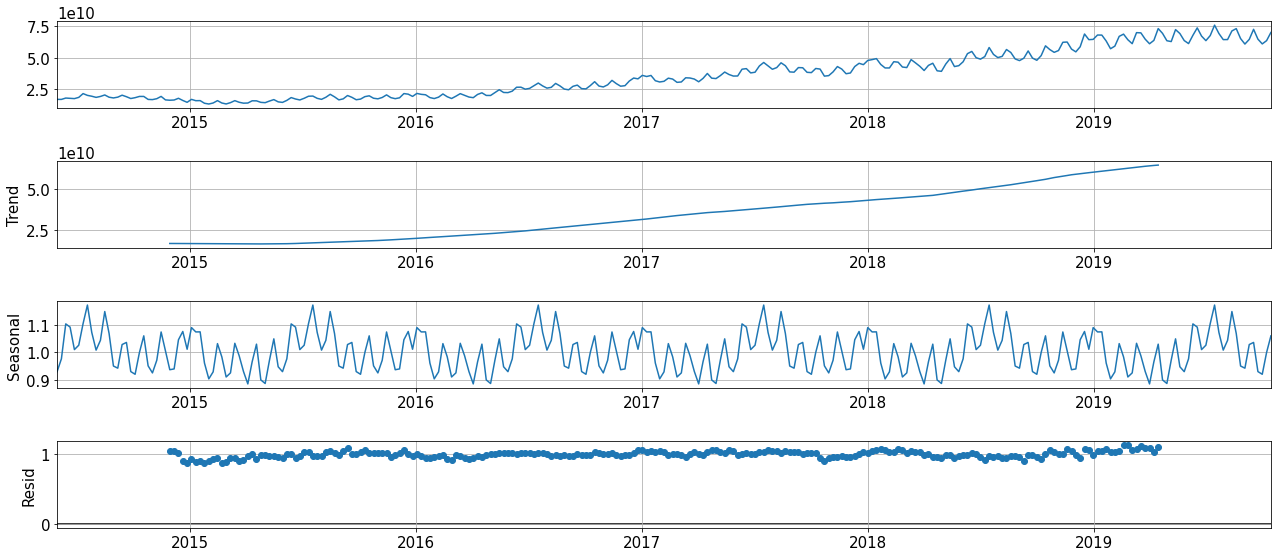

In [176]:
ts_dicomposition = seasonal_decompose(dataset1, model='multiplicate')
ts_dicomposition.plot();


График не имеет ярких выбрлсов и имеет закономерность, значит ряд  не стационарный.

,value
count,2.810000e+02
mean,3.601189e+10
std,1.776124e+10
min,1.356953e+10
25%,1.930714e+10
50%,3.317428e+10
75%,4.882917e+10
max,7.556869e+10


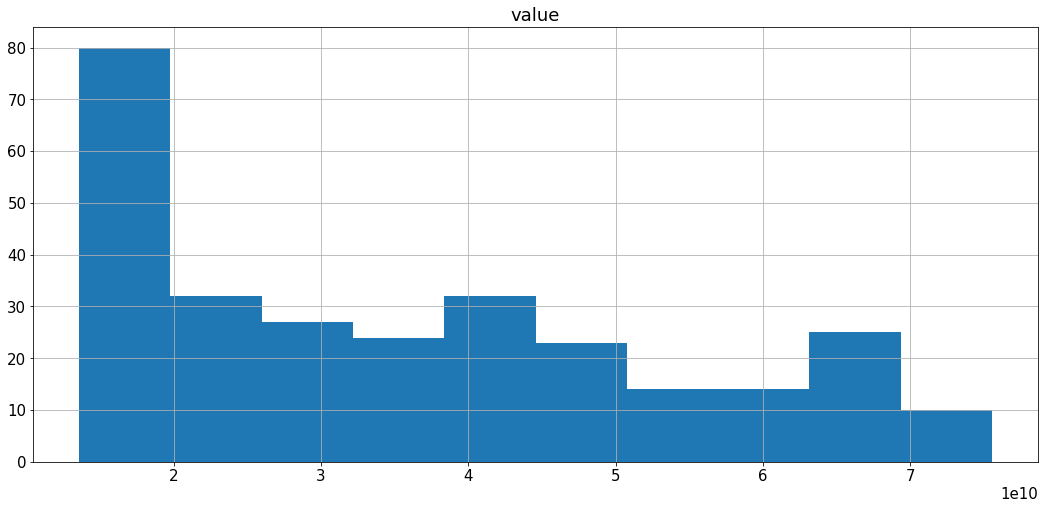

In [177]:
itog = dataset1.describe()
dataset1.hist()
itog

Заметим не однородный график. Посчитаем коэффициент вариации.

In [178]:
from statsmodels.iolib.table import SimpleTable
import numpy as np
from statsmodels.stats.stattools import jarque_bera  
row=[u'JB',u'p-value',u'skew',u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataset1)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)


         JB         
--------------------
  24.836828228417446
4.04344254308925e-06
  0.5372387132126283
   2.016743574767504
--------------------


In [179]:
test = sm.tsa.adfuller(dataset1)

print(f'adf: {test[0]}') # может стоит использовать f-strings - форматирование строк
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf: 1.1558958623857554
p-value:  0.9956665401966323
Critical values:  {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
есть единичные корни, ряд не стационарен


In [180]:
otgdiff = dataset1.diff(periods=1).dropna()

In [181]:
test = sm.tsa.adfuller(otgdiff)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])

if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else: 
    print('единичных корней нет,ряд стационарный')
    

adf: -5.874946960452744
p-value: 3.175618721642911e-07
Critical values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
единичных корней нет,ряд стационарный


Построим график и посмотрим на тренд для графика. 

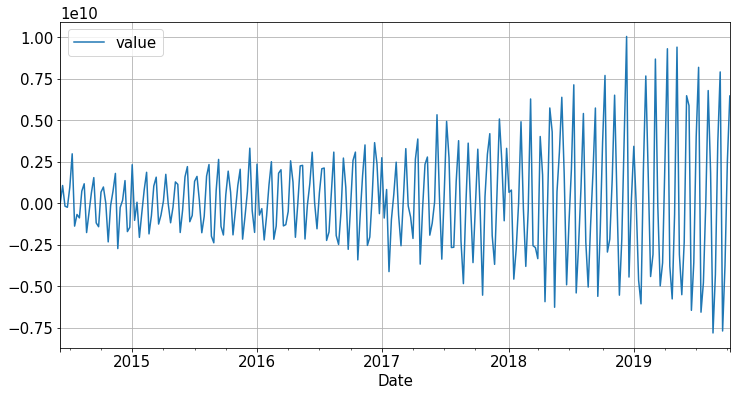

In [182]:
otgdiff.plot(figsize=(12,6))

Видим что тренда нет и таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

In [183]:
dataset1

,value
Date,
2014-06-01,1.720682e+10
2014-06-08,1.718698e+10
2014-06-15,1.824927e+10
2014-06-22,1.806436e+10
2014-06-29,1.781468e+10
...,...
2019-09-15,7.227318e+10
2019-09-22,6.456505e+10
2019-09-29,6.080820e+10


<a id='Arima '></a>

# Arima 

**Построение модели** 


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

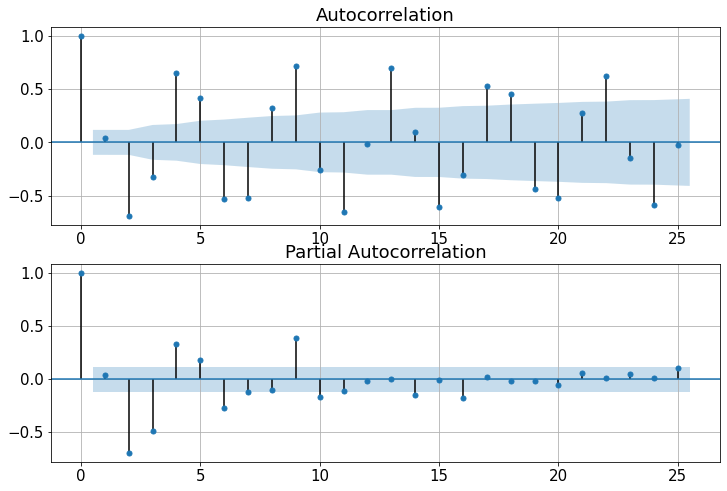

In [184]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otgdiff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otgdiff, lags=25, ax=ax2)

In [185]:
src_data_model = dataset1[:'2019-06-10']
model = sm.tsa.ARIMA(src_data_model, order=(2, 1, 2), freq='W').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available',

In [186]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  262
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5942.154
Method:                       css-mle   S.D. of innovations     1629539807.795
Date:                Fri, 30 Sep 2022   AIC                          11896.308
Time:                        20:49:12   BIC                          11917.718
Sample:                    06-08-2014   HQIC                         11904.913
                         - 06-09-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.921e+08        nan        nan        nan         nan         nan
ar.L1.D.value     0.2520        nan        nan        nan         nan         nan
ar.L2.D.value    -1.0000        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [187]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [188]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
pred = model.predict('2019-05-26','2020-12-31', typ='levels')
trn = dataset1['2019-05-26':]
r2 = r2_score(trn, pred[0:len(trn)])
print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(trn, pred[0:len(trn)]))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trn, pred[0:len(trn)])))
print('Mean Absolute Error:', metrics.mean_absolute_error(trn, pred[0:len(trn)])) 

R^2: 0.64
Mean Squared Error: 6.698681560004056e+18
Root Mean Squared Error: 2588181129.674671
Mean Absolute Error: 1995610361.8549478


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


nan был из-за того что в данных были пропуски

In [189]:
# metrics.rmse(trn, pred[0:len(trn)])

Попробуем предсказать...

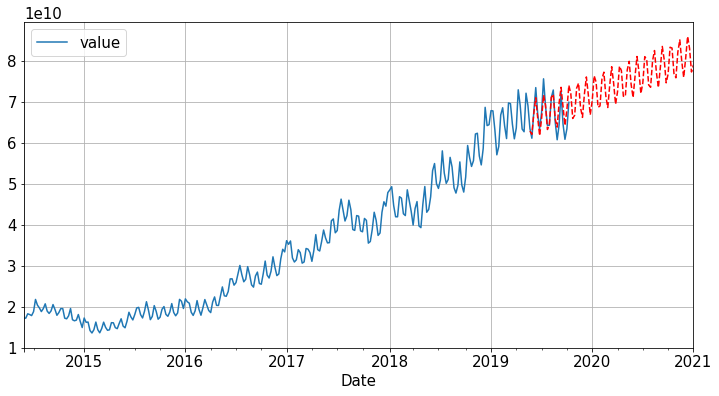

In [190]:
dataset1.plot(figsize=(12,6))
pred.plot(style='r--');


In [191]:
dt_pred=dataset1['2019-05-15':]


dt_pred['pred']=pred
dt_pred.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,value,pred
Date,,
2019-05-19,6.896488e+10,NaN
2019-05-26,6.344489e+10,6.281363e+10
2019-06-02,6.107306e+10,6.202695e+10
2019-06-09,6.754772e+10,6.714921e+10
2019-06-16,7.342399e+10,7.093817e+10
2019-06-23,6.696145e+10,6.600435e+10
2019-06-30,6.337888e+10,6.170642e+10
2019-07-07,6.738229e+10,6.589300e+10
2019-07-14,7.556869e+10,7.158183e+10


Как можно улучшть качество предсказаний?

Попробуем еще предсказать ряд..

# LSTM

Попробую LSTM (спойлер ничего не получилось( )

In [192]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [193]:
dataset = dataset1.value.values
dataset = dataset.astype('float32')

In [194]:
dataset = dataset.reshape(-1,1)

In [195]:
dataset

array([[1.7206823e+10],
       [1.7186984e+10],
       [1.8249267e+10],
       [1.8064359e+10],
       [1.7814680e+10],
       [1.8773948e+10],
       [2.1747378e+10],
       [2.0361720e+10],
       [1.9678185e+10],
       [1.8788387e+10],
       [1.9513002e+10],
       [2.0680108e+10],
       [1.8907214e+10],
       [1.8338236e+10],
       [1.8959581e+10],
       [2.0497451e+10],
       [1.9307137e+10],
       [1.7885346e+10],
       [1.8549379e+10],
       [1.9522273e+10],
       [1.9516819e+10],
       [1.7180248e+10],
       [1.7028229e+10],
       [1.7746637e+10],
       [1.9537871e+10],
       [1.6799662e+10],
       [1.6540230e+10],
       [1.6710723e+10],
       [1.8069002e+10],
       [1.6353632e+10],
       [1.4898482e+10],
       [1.7214996e+10],
       [1.6177120e+10],
       [1.6230516e+10],
       [1.4165692e+10],
       [1.3569532e+10],
       [1.4368630e+10],
       [1.6227653e+10],
       [1.4373026e+10],
       [1.3607874e+10],
       [1.4641618e+10],
       [1.620620

In [196]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [197]:
# split into train and test sets
train_size = int(len(dataset) * 0.86)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

241 40


In [198]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [199]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [200]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [201]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
239/239 - 3s - loss: 0.0549 - 3s/epoch - 10ms/step
Epoch 2/100
239/239 - 0s - loss: 0.0252 - 368ms/epoch - 2ms/step
Epoch 3/100
239/239 - 0s - loss: 0.0170 - 353ms/epoch - 1ms/step
Epoch 4/100
239/239 - 0s - loss: 0.0097 - 346ms/epoch - 1ms/step
Epoch 5/100
239/239 - 0s - loss: 0.0049 - 362ms/epoch - 2ms/step
Epoch 6/100
239/239 - 0s - loss: 0.0026 - 343ms/epoch - 1ms/step
Epoch 7/100
239/239 - 0s - loss: 0.0020 - 353ms/epoch - 1ms/step
Epoch 8/100
239/239 - 0s - loss: 0.0018 - 365ms/epoch - 2ms/step
Epoch 9/100
239/239 - 0s - loss: 0.0018 - 342ms/epoch - 1ms/step
Epoch 10/100
239/239 - 0s - loss: 0.0019 - 360ms/epoch - 2ms/step
Epoch 11/100
239/239 - 0s - loss: 0.0018 - 358ms/epoch - 1ms/step
Epoch 12/100
239/239 - 0s - loss: 0.0019 - 345ms/epoch - 1ms/step
Epoch 13/100
239/239 - 0s - loss: 0.0019 - 343ms/epoch - 1ms/step
Epoch 14/100
239/239 - 0s - loss: 0.0018 - 347ms/epoch - 1ms/step
Epoch 15/100
239/239 - 0s - loss: 0.0019 - 350ms/epoch - 1ms/step
Epoch 16/100
239/239 

In [202]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [203]:
testPredict

array([[0.8467213 ],
       [0.7862841 ],
       [0.7027228 ],
       [0.731507  ],
       [0.8339374 ],
       [0.856336  ],
       [0.7993495 ],
       [0.7578743 ],
       [0.8709282 ],
       [0.8688615 ],
       [0.80514663],
       [0.7569811 ],
       [0.7926329 ],
       [0.9099071 ],
       [0.86358064],
       [0.7891397 ],
       [0.78035057],
       [0.9000297 ],
       [0.8620711 ],
       [0.79090124],
       [0.7589829 ],
       [0.8442187 ],
       [0.91634566],
       [0.83674824],
       [0.7900237 ],
       [0.84211576],
       [0.94142604],
       [0.8624408 ],
       [0.8008154 ],
       [0.80132276],
       [0.8874259 ],
       [0.9093848 ],
       [0.8115469 ],
       [0.75387746],
       [0.8030599 ],
       [0.9026143 ],
       [0.80569786],
       [0.7553695 ]], dtype=float32)

In [204]:
for_sub = pd.DataFrame(testPredict)
for_sub = for_sub.rename({0:'RUL'}, axis=1)
for_sub.index.name = 'id'
for_sub.RUL = for_sub.RUL.round().astype('int')

In [205]:
for_sub.head()

,RUL
id,
0,1
1,1
2,1
3,1
4,1


Еще подумаю что не так ;(

# Минимум в месяц

предскажем минимальное значение объема,при подготовке обучающих данных при группировке по месяцу возьмем минимальные значения.

**mint∈time(value0..valuet)**











In [206]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dataset.dropna(subset=['value'], how='all')

,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [207]:


df_min=dataset1.groupby(pd.Grouper( axis=0, 
                      freq='m')).min()
                      
df_min                  

,value
Date,
2014-06-30,1.718698e+10
2014-07-31,1.877395e+10
2014-08-31,1.833824e+10
2014-09-30,1.788535e+10
2014-10-31,1.718025e+10
...,...
2019-06-30,6.107306e+10
2019-07-31,6.419393e+10
2019-08-31,6.423243e+10


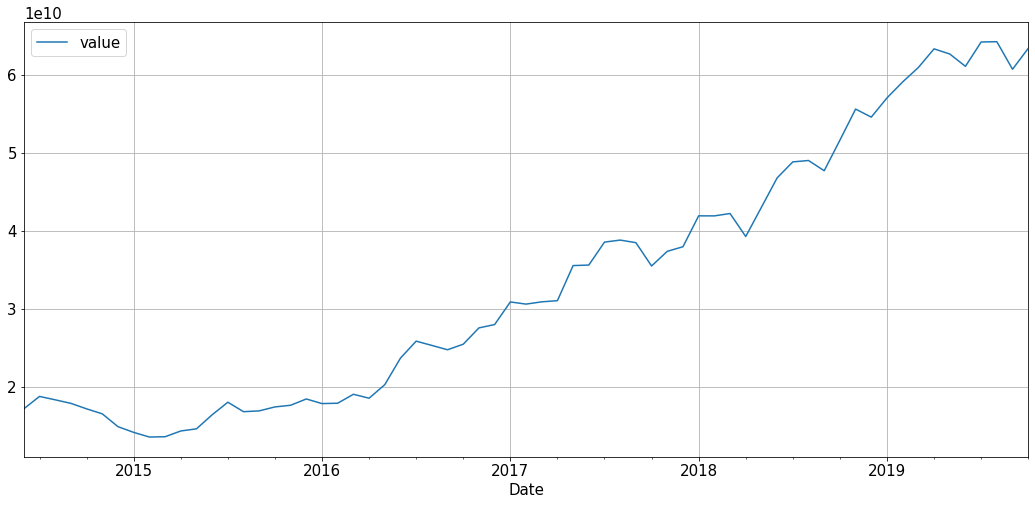

In [208]:
df_min.plot(y='value')




Train dates : 2014-06-30 00:00:00 --- 2019-05-31 00:00:00  (n=60)
Test dates  : 2019-06-30 00:00:00 --- 2019-10-31 00:00:00  (n=5)


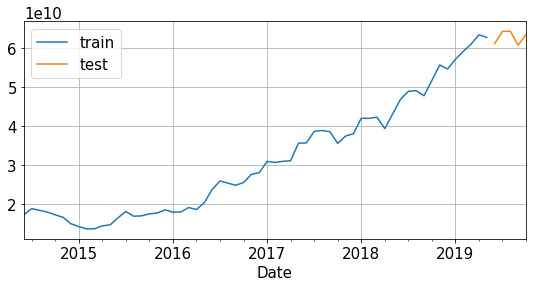

In [209]:
steps = 5
data_train = df_min[:-steps]
data_test  = df_min[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

С помощью чего предсказать мин значения? Существенно меньше данных стало ((

# Skforecast

Попрробуем еще так(тоже как то неочень )

In [211]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 168 kB 7.9 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 283 kB 50.8 MB/s 
     |████████████████████████████████| 100 kB 9.4 MB/s 
     |████████████████████████████████| 308 kB 48.3 MB/s 
     |████████████████████████████████| 11.2 MB 36.2 MB/s 
     |████████████████████████████████| 209 kB 39.7 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 960 kB 52.9 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 112 kB 41.3 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 147 kB 64.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=f684a12fe

In [213]:

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

Попробуем библиотеку Skforecast (спойлер предсказания тоже такие себе) 

Train dates : 2014-06-01 00:00:00 --- 2019-02-03 00:00:00  (n=245)
Test dates  : 2019-02-10 00:00:00 --- 2019-10-13 00:00:00  (n=36)


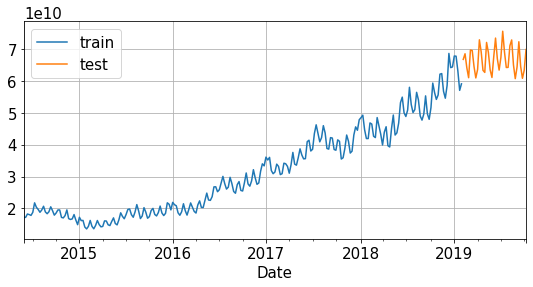

In [214]:
steps = 36
data_train = dataset1[:-steps]
data_test  = dataset1[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [215]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['value'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2019-02-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-30 20:50:40 
Last fit date: 2022-09-30 20:50:40 
Skforecast version: 0.5.0 
Python version: 3.7.14 

In [216]:
# Predictions
# ==============================================================================
steps = 36

predictions = forecaster.predict(steps=steps)


data_test['pred']=predictions
data_test.head(15)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,value,pred
Date,,
2019-02-10,6.674185e+10,6.140721e+10
2019-02-17,6.850709e+10,6.230516e+10
2019-02-24,6.408280e+10,6.099774e+10
2019-03-03,6.099172e+10,6.280820e+10
2019-03-10,6.967669e+10,6.396835e+10
2019-03-17,6.951006e+10,6.536895e+10
2019-03-24,6.452308e+10,6.549136e+10
2019-03-31,6.092624e+10,6.572042e+10
2019-04-07,6.357528e+10,6.544398e+10


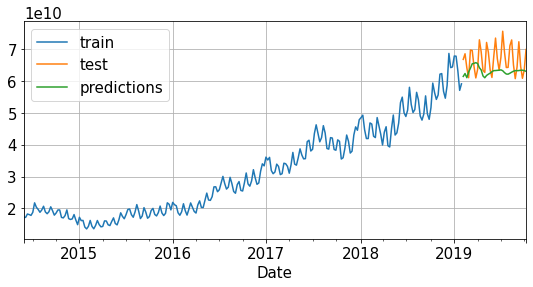

In [217]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [218]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['value'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 3.0806186296482873e+19


In [219]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 40
             )

forecaster.fit(y=data_train['value'])

In [220]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

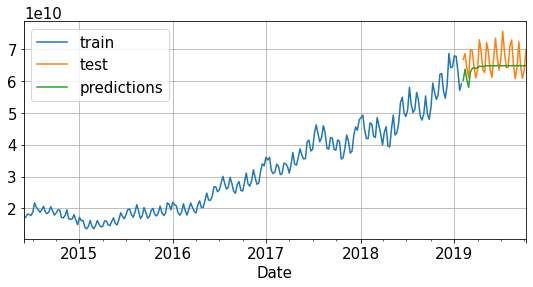

In [221]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [222]:
predictions

2019-02-10    6.014645e+10
2019-02-17    6.365778e+10
2019-02-24    6.045317e+10
2019-03-03    5.794471e+10
2019-03-10    6.280293e+10
2019-03-17    6.387415e+10
2019-03-24    6.418641e+10
2019-03-31    6.385605e+10
2019-04-07    6.411368e+10
2019-04-14    6.459136e+10
2019-04-21    6.451838e+10
2019-04-28    6.454352e+10
2019-05-05    6.462140e+10
2019-05-12    6.475368e+10
2019-05-19    6.475304e+10
2019-05-26    6.474227e+10
2019-06-02    6.475304e+10
2019-06-09    6.475304e+10
2019-06-16    6.475304e+10
2019-06-23    6.481112e+10
2019-06-30    6.475304e+10
2019-07-07    6.475304e+10
2019-07-14    6.475304e+10
2019-07-21    6.475304e+10
2019-07-28    6.475304e+10
2019-08-04    6.475304e+10
2019-08-11    6.475304e+10
2019-08-18    6.475304e+10
2019-08-25    6.475304e+10
2019-09-01    6.475304e+10
2019-09-08    6.475304e+10
2019-09-15    6.475304e+10
2019-09-22    6.475304e+10
2019-09-29    6.475304e+10
2019-10-06    6.475304e+10
2019-10-13    6.475304e+10
Freq: W-SUN, Name: pred, dty

# Обогатим данные

Попробуем обогатить данные и добавить курс $ и € 

In [224]:

dt_d = pd.read_csv('doll.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                  
                   infer_datetime_format="%d/%m/%y")
dt_d

,Doll
Date,
2014-06-02,0.735
2014-06-03,0.734
2014-06-04,0.7343
2014-06-05,0.7343
2014-06-06,0.7332
...,...
2019-12-25,ND
2019-12-26,0.9007
2019-12-27,0.8949


In [225]:
dataset_doll = dataset1.join(dt_d['Doll']) # :(((
dataset_doll   

,value,Doll
Date,,
2014-06-01,1.720682e+10,NaN
2014-06-08,1.718698e+10,NaN
2014-06-15,1.824927e+10,NaN
2014-06-22,1.806436e+10,NaN
2014-06-29,1.781468e+10,NaN
...,...,...
2019-09-15,7.227318e+10,NaN
2019-09-22,6.456505e+10,NaN
2019-09-29,6.080820e+10,NaN


Почему Nan ?((

# Лин регрессия 

Попробуем наконец линейную регрессию и градиентный бустинг

In [226]:
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [227]:
columns=['Date', 'value']
dt = pd.read_csv('data_1.csv', parse_dates=['Date'], dayfirst=True, header=None, names=columns)


In [228]:
dataset1

,value
Date,
2014-06-01,1.720682e+10
2014-06-08,1.718698e+10
2014-06-15,1.824927e+10
2014-06-22,1.806436e+10
2014-06-29,1.781468e+10
...,...
2019-09-15,7.227318e+10
2019-09-22,6.456505e+10
2019-09-29,6.080820e+10


Извлечем особености из дат

In [229]:
def create_features(dataset1, label=None):
    """
    Creates time series features from datetime index
    """
    dataset1['date'] = dataset1.index
    dataset1['dayofweek'] = dataset1['date'].dt.dayofweek
    dataset1['quarter'] = dataset1['date'].dt.quarter
    dataset1['month'] = dataset1['date'].dt.month
    dataset1['year'] = dataset1['date'].dt.year
    dataset1['dayofyear'] = dataset1['date'].dt.dayofyear
    dataset1['dayofmonth'] = dataset1['date'].dt.day
    dataset1['weekofyear'] = dataset1['date'].dt.weekofyear
    
    X = dataset1[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dataset1[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [230]:
X_train, y_train = create_features(data_train, label='value')
X_test, y_test = create_features(data_test, label='value')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [231]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,
2014-06-01,6,2,6,2014,152,1,22
2014-06-08,6,2,6,2014,159,8,23
2014-06-15,6,2,6,2014,166,15,24
2014-06-22,6,2,6,2014,173,22,25
2014-06-29,6,2,6,2014,180,29,26
...,...,...,...,...,...,...,...
2019-01-06,6,1,1,2019,6,6,1
2019-01-13,6,1,1,2019,13,13,2
2019-01-20,6,1,1,2019,20,20,3


In [232]:
scaler = StandardScaler()
scaler.fit(dataset1 ) 
scaled_df = scaler.transform(dataset1)

In [233]:
steps = 36
data_train = dt[:-steps]
data_test  = dt[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 0 --- 2074  (n=2075)
Test dates  : 2075 --- 2110  (n=36)


In [234]:
X = data_train .drop('value', axis=1)
y = data_train ['value']

In [235]:
model = LinearRegression()
model.fit(X_train, y_train)

importance = model.coef_

In [236]:
model = LinearRegression()
model.fit(X_train, y_train) 
importance = model.coef_
sorted(list(zip(X_train.columns, importance)), 
       key=lambda x: abs(x[1]))

[('dayofweek', 0.0),
 ('weekofyear', 48917150.16934934),
 ('quarter', 513530714.2559347),
 ('dayofmonth', 1073381258.9141357),
 ('dayofyear', -1079102784.5369475),
 ('year', 9823913143.599543),
 ('month', 33529113326.348255)]

In [237]:
pd.DataFrame({
    'variable': X_train.columns,
    'coef': model.coef_ 
}) \
  .round(decimals=2)\
  .sort_values('coef',ascending=False)\
  .style.bar(color=["grey",'lightblue'],align='zero')

,variable,coef
2,month,33529113326.349998
3,year,9823913143.600000
5,dayofmonth,1073381258.910000
1,quarter,513530714.260000
6,weekofyear,48917150.170000
0,dayofweek,0.000000
4,dayofyear,-1079102784.540000


In [238]:
y_predict = model.predict(X_test)
y_predict

array([5.22135072e+10, 5.22223737e+10, 5.22312402e+10, 5.57145447e+10,
       5.57234112e+10, 5.57322777e+10, 5.57411441e+10, 5.57500106e+10,
       5.65267021e+10, 5.65355686e+10, 5.65444350e+10, 5.65533015e+10,
       5.78898435e+10, 5.78987100e+10, 5.79075765e+10, 5.79164429e+10,
       5.81796037e+10, 5.81884702e+10, 5.81973366e+10, 5.82062031e+10,
       5.82150696e+10, 6.00651423e+10, 6.00740088e+10, 6.00828753e+10,
       6.00917417e+10, 6.03549025e+10, 6.03637690e+10, 6.03726355e+10,
       6.03815019e+10, 6.06446627e+10, 6.06535292e+10, 6.06623956e+10,
       6.06712621e+10, 6.06801286e+10, 6.25302013e+10, 6.25390678e+10])

In [239]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict)) 
print('R2', r2_score(y_test,y_predict))

Mean Squared Error: 9.36950034981638e+19
Root Mean Squared Error: 9679617941.745625
Mean Absolute Error: 8450809885.009563
R2 -4.616195351463827


In [240]:
for_sub = pd.DataFrame(model.predict(X_test))
for_sub = for_sub.rename({0:'value_pred'}, axis=1)

for_sub.value_pred = for_sub.value_pred.round().astype('int')

In [241]:

for_sub  #как соединить с датой вместо индекса? :((

,value_pred
0,52213507225
1,52222373695
2,52231240166
3,55714544714
4,55723411185
5,55732277655
6,55741144126
7,55750010597
8,56526702082
9,56535568553


In [242]:
y_test

Date
2019-02-10    6.674185e+10
2019-02-17    6.850709e+10
2019-02-24    6.408280e+10
2019-03-03    6.099172e+10
2019-03-10    6.967669e+10
2019-03-17    6.951006e+10
2019-03-24    6.452308e+10
2019-03-31    6.092624e+10
2019-04-07    6.357528e+10
2019-04-14    7.288238e+10
2019-04-21    6.908578e+10
2019-04-28    6.331243e+10
2019-05-05    6.265431e+10
2019-05-12    7.205835e+10
2019-05-19    6.896488e+10
2019-05-26    6.344489e+10
2019-06-02    6.107306e+10
2019-06-09    6.754772e+10
2019-06-16    7.342399e+10
2019-06-23    6.696145e+10
2019-06-30    6.337888e+10
2019-07-07    6.738229e+10
2019-07-14    7.556869e+10
2019-07-21    6.899448e+10
2019-07-28    6.419393e+10
2019-08-04    6.423243e+10
2019-08-11    7.101858e+10
2019-08-18    7.283859e+10
2019-08-25    6.501165e+10
2019-09-01    6.069904e+10
2019-09-08    6.436435e+10
2019-09-15    7.227318e+10
2019-09-22    6.456505e+10
2019-09-29    6.080820e+10
2019-10-06    6.337633e+10
2019-10-13    6.983502e+10
Freq: W-SUN, Name: valu

In [243]:
# Predictions
# ==============================================================================



data_test['pred']=for_sub
data_test.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,value,pred
2075,2019-05-09,63567657923,NaN
2076,2019-06-09,67827416879,NaN
2077,2019-07-09,67827416879,NaN
2078,2019-08-09,67827416879,NaN
2079,2019-09-09,68188394412,NaN
2080,2019-10-09,69394145963,NaN
2081,2019-11-09,75448010881,NaN
2082,2019-12-09,74105978838,NaN
2083,2019-09-13,72925242456,NaN
2084,2019-09-14,72925242456,NaN


# xgboost

In [244]:
dataset1

,value
Date,
2014-06-01,1.720682e+10
2014-06-08,1.718698e+10
2014-06-15,1.824927e+10
2014-06-22,1.806436e+10
2014-06-29,1.781468e+10
...,...
2019-09-15,7.227318e+10
2019-09-22,6.456505e+10
2019-09-29,6.080820e+10


In [245]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


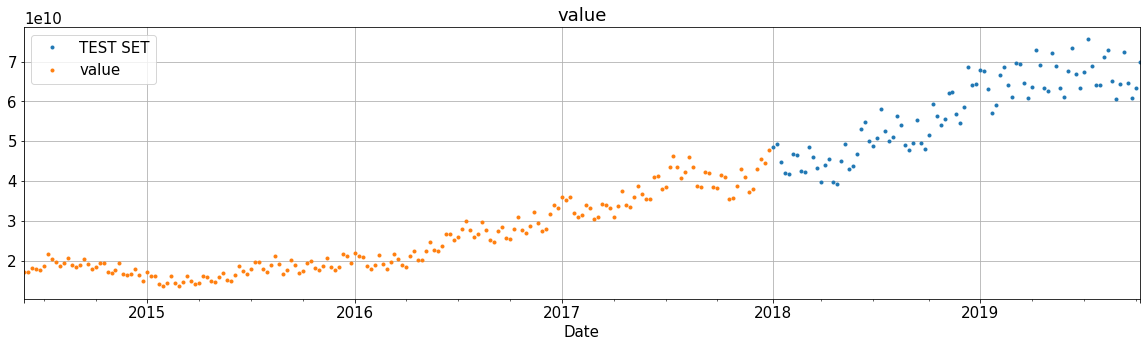

In [246]:
temp = dataset1[['value']]
split_date = '2018-01'
temp_train = temp.loc[temp.index <= split_date].copy()
temp_test = temp.loc[temp.index > split_date].copy()
_ = temp_test.rename(columns={'value': 'TEST SET'})\
    .join(temp_train.rename(columns={'valueP': 'TRAINING SET'}),how='outer') \
    .plot(figsize=(20,5), title='value', style='.')

In [247]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) 

[20:51:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.12149e+10	validation_1-rmse:6.16903e+10
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.82191e+10	validation_1-rmse:5.71297e+10
[2]	validation_0-rmse:2.55236e+10	validation_1-rmse:5.30189e+10
[3]	validation_0-rmse:2.30995e+10	validation_1-rmse:4.93137e+10
[4]	validation_0-rmse:2.09187e+10	validation_1-rmse:4.59743e+10
[5]	validation_0-rmse:1.8958e+10	validation_1-rmse:4.29647e+10
[6]	validation_0-rmse:1.71965e+10	validation_1-rmse:4.02525e+10
[7]	validation_0-rmse:1.56123e+10	validation_1-rmse:3.78445e+10
[8]	validation_0-rmse:1.41865e+10	validation_1-rmse:3.58273e+10
[9]	validation_0-rmse:1.2905e+10	validation_1-rmse:3.40085e+10
[10]	validation_0-rmse:1.17273e+10	validation_1-rmse:3.17471e+10
[11]	valida

XGBRegressor()

In [248]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [249]:
regressor.fit(X_train, y_train)

[20:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [250]:
y_pred = regressor.predict(X_test)

In [251]:
mean_squared_error(y_test, y_pred)

6.1019705499711685e+19

In [252]:
y_pred

array([6.0179423e+10, 6.1400699e+10, 5.7029513e+10, 5.7829745e+10,
       6.0179423e+10, 6.1400699e+10, 5.7029513e+10, 5.6142111e+10,
       5.9785392e+10, 6.1977371e+10, 5.9333104e+10, 5.6838136e+10,
       5.9040018e+10, 6.1344653e+10, 5.9762491e+10, 5.6998556e+10,
       5.8020073e+10, 5.9148071e+10, 6.1865742e+10, 5.8287120e+10,
       5.6210715e+10, 5.9131027e+10, 6.2687588e+10, 6.0067115e+10,
       5.7572143e+10, 5.8363888e+10, 6.1982896e+10, 6.2024131e+10,
       5.6278344e+10, 5.6865874e+10, 5.8828702e+10, 6.1742047e+10,
       5.7779786e+10, 5.5547204e+10, 5.8936435e+10, 6.4603316e+10],
      dtype=float32)

In [253]:
for_sub1 = pd.DataFrame(regressor.predict(X_test))
for_sub1 = for_sub.rename({0:'value_pred'}, axis=1)

for_sub1.value_pred = for_sub.value_pred.round().astype('int')
for_sub1

,value_pred
0,52213507225
1,52222373695
2,52231240166
3,55714544714
4,55723411185
5,55732277655
6,55741144126
7,55750010597
8,56526702082
9,56535568553


# Решение Сбера

В процессе


Их решения на R
```
# library(kernlab)
library(dplyr)
library(zoo)

data=read.csv2('data.csv', header = T, stringsAsFactors = F)
data$REPORTDATE = as.Date(data$REPORTDATE,format = '%d.%m.%Y')

#Логарифмируем объемы

data$VALUE = log(data$VALUE)

#Функция расчета стабильной части на дату

stableOnDate = function(report_date, data){
  
  
  h  = 366
  t = report_date + -h:365
  
  
  
  df = filter(data, REPORTDATE > report_date - h, REPORTDATE <= report_date)
  
  #масштабируем данные
  y  = df$VALUE; my = mean(y) ; sdy = sd(y);   y = (y - my)/sdy
  
  
  x_and_xpredict = 1:(h+365) 
  
  
  L = length(x_and_xpredict)
  
  
  
  
  
  
  
  trend    = function(x,y)   1/(x+365) * 1/(y+365)
  seasonRBF = function(len,period) function(x,y) exp(- (1/(len)^2)* 2*(sin(pi*abs(x-y)/period))^2  )
  
  #Применить функцию к попарным значениям
  makeMat   = function(x,fun) outer(x,x,fun)
  
  #Масштабируем матрицу тренда
  Ktrend   = makeMat(x_and_xpredict,trend) ; Ktrend = (Ktrend - mean(Ktrend)); Ktrend = (Ktrend)/max(Ktrend)
  Season  = function(x,f)   makeMat(x_and_xpredict,seasonRBF(1,x) )
  
  
  
  
  
  
  M  = 1:h
  M2 = 1:L ; M2 = M2[!M2 %in% M]
  
  
  
  makeFitandPredict = function(K,y,q){
    
    K_train = K[M,M] ; class(K_train) <- "kernelMatrix"
    K_pred  = K[M2,M] ; class(K_pred) <- "kernelMatrix"
    model   = kqr(K_train,y,tau=q)
    fit     = predict(model,K_train)
    pred    = predict(model,K_pred) 
    list(fit = fit,pred = pred)
  }
  
  
  K    =  1e2*Ktrend   + diag(0.1,L,L)
  res  =  makeFitandPredict(K,y,0.01)
  
  
  pred = res$pred 
  fit  = res$fit
  
  residuals = y - fit
  
  
  K    =    1e2*Season(365) + diag(0.1,L,L) 
  res2 =    makeFitandPredict(K,residuals,0.01)
  
  
  pred = res2$pred + pred 
  fit  = res2$fit + fit
  
  
  
  #Обратное масштабирование
  pred = pred*sdy  + my
  fit  = fit*sdy   + my
  
  
  #Бакеты
  ts      = seq(365/12,365,365/12)
  
  #Посчитаем для каждого бакета стабильную часть
  stable_levels = lapply(ts,function(t) c(last(df$VALUE),head(pred,t))%>% min)
  stable_levels = as.numeric(stable_levels)
  names = c('1m','2m','3m','4m','5m','6m','7m','8m','9m','10m','11m','12m')
  
  
  
  res   = data.frame(report_date = report_date,
                     bucket = names,
                     stable = stable_levels
  )
  
  
}








#Факт стабильной части на дату на горизонте h, на дату report_date
stablesFact = function(h,report_date,data=data){
  df = filter(data,REPORTDATE <= report_date+h, REPORTDATE >= report_date)
  min(df$VALUE)
}
  


#Cравниваем

t = as.Date('2018-08-23')
model = stableOnDate(t,data)

stab31 = stablesFact(31,t,data) %>% exp

model31 = filter(model, bucket == '1m')$stable %>% exp

```


  




In [258]:
data=dataset1
data

,value
Date,
2014-06-01,1.720682e+10
2014-06-08,1.718698e+10
2014-06-15,1.824927e+10
2014-06-22,1.806436e+10
2014-06-29,1.781468e+10
...,...
2019-09-15,7.227318e+10
2019-09-22,6.456505e+10
2019-09-29,6.080820e+10


прологарефмируе  как они...?

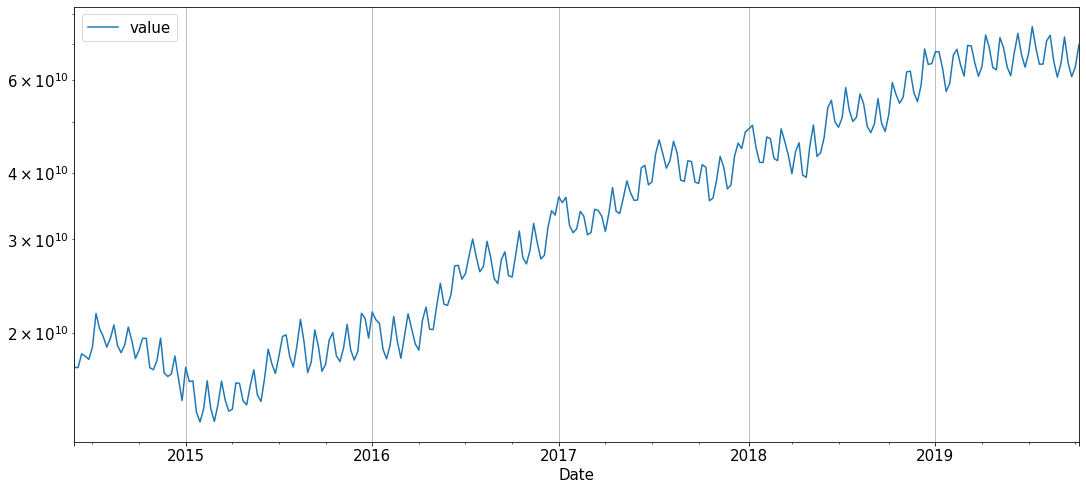

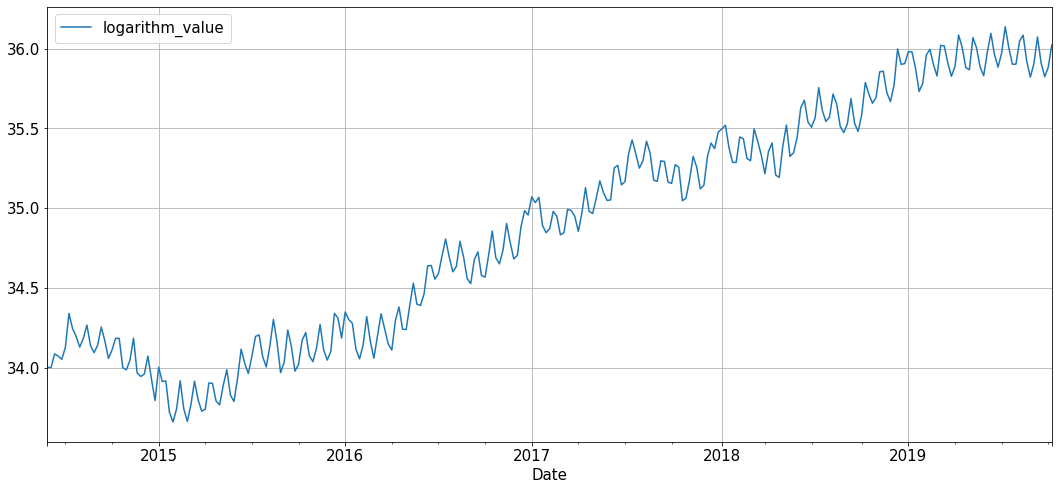

In [259]:
from matplotlib import pyplot
data.plot(y='value')
pyplot.yscale('log')
pyplot.show()
data['logarithm_value'] = np.log2(data['value'])
data.plot(y='logarithm_value')

In [260]:
def stableOnDate(report_date, data):
  h  = 366
  t = report_date + (-h/365)
  df = filter(data, REPORTDATE > report_date - h, REPORTDATE <= report_date)
  y  = df['value']
  my = mean(y) 
  sdy = sd(y)
  y = (y - my)/sdy
  x_and_xpredict = 1/(h+365) 
  L = len(x_and_xpredict)

  def trend(x,y): 
      1/(x+365) * 1/(y+365)

  def  seasonRBF(len,period):   
    exp(- (1/(len)^2)* 2*(sin(pi*abs(x-y)/period))^2  )
  

  def  makeMat(x,fun):
    outer(x,x,fun)

  #Применить функцию к попарным значениям

  #Масштабируем матрицу тренда
  Ktrend   = makeMat(x_and_xpredict,trend) ; 
  Ktrend = (Ktrend - mean(Ktrend));
  Ktrend = (Ktrend)/max(Ktrend)
  def   Season(x,f):
    makeMat(x_and_xpredict,seasonRBF(1,x) )

  M  = 1/h
  M2 = 1/L 
  #M2 = M2[!M2 %in% M] ???

  #....
